# Notebook de Alexandre

Ici, Alexandre peut faire ses tests pour les parties du sujet dont il s'occupe.

Bon courage Alexandre :)

## Import necessary libraries

In [883]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil as su
import random as rd
import cv2

## Load data

In [884]:
%%bash
mkdir -p tmp_data
rm -rf tmp_data/*
mkdir -p tmp_data/train_set
mkdir -p tmp_data/test_set

## Separate training dataset

In [885]:
def separate_data(path, nb_elements=1):
    """
    Separate given data in `path` in two sets with `nb_elements` per class for test

    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.

    nb_elements: integer
        Defines the number of test images taken in each class of the dataset
    """
    labels_path = os.path.join(path, "labels.txt")
    images_path = path
    test_path = 'tmp_data/test_set'
    train_path = 'tmp_data/train_set'

    
    labels = np.empty((0, 1))
    names = np.empty((0, 1))
    with open(labels_path) as f:
        for current_label in f:
            if current_label == "\n":
                continue
            label, name = current_label.split(": ")
            labels = np.append(labels, label)
            names = np.append(names, name)

    for label in labels:
        pre_label = 'img_' + label + '_'
        curr_test_path = os.path.join(test_path, label)
        curr_train_path = os.path.join(train_path, label)
        os.makedirs(curr_test_path, exist_ok=True)
        os.makedirs(curr_train_path, exist_ok=True)

        current_path = os.path.join(images_path, label)
        datas = os.listdir(current_path)
        rd.shuffle(datas)

        count = 0
        for data in datas:
            data_path = os.path.join(current_path, data)
            if count < nb_elements:
                su.copyfile(data_path, os.path.join(curr_test_path, pre_label + str(count) + '.png'))
            else:
                su.copyfile(data_path, os.path.join(curr_train_path, pre_label + str(count - nb_elements) + '.png'))
            count += 1

    return labels, names

In [886]:
ref = separate_data('ressources/train', 2)

## Get separated datasets

In [887]:
def get_datasets(kind='train'):
    """
    Returns `kind` set and their label

    Parameters
    ----------
    kind: str (train or test)
        Type of dataset we want to get
    """
    assert kind == 'train' or kind == 'test'
    dataset_path = 'tmp_data/train_set' if kind == 'train' else 'tmp_data/test_set'
    
    images = []
    labels = []
    dirs = os.listdir(dataset_path)

    for folder in dirs : 
        curr_path = os.path.join(dataset_path, folder)
        datas = os.listdir(curr_path)
        for data in datas:
            data_path = os.path.join(curr_path, data)
            img = cv2.imread(data_path);
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
            images.append(img)
            labels.append(folder)
    
    return labels, images

In [888]:
train_labels, train_images = get_datasets('train')
test_labels, test_images = get_datasets('test')

## Shuffle datasets

In [889]:
def shuffle_set(labels, images):
    """
    Shuffles equally labels and images

    Parameters
    ----------
    labels: [str]
        Dataset's labels
        
    images: [image]
        Dataset's images
    """
    assert len(labels) == len(images)
    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)
    new_labels = np.array(labels)
    new_images = np.array(images, dtype=object)
    
    for ii in range(shuffle_index.size):
        new_labels[ii] = labels[shuffle_index[ii]]
        new_images[ii] = images[shuffle_index[ii]]
        
    return new_labels, new_images

In [890]:
#train_labels, train_images = shuffle_set(train_labels, train_images)
#test_labels, test_images = shuffle_set(test_labels, test_images)

## Print train example

01
['lunettes\n']


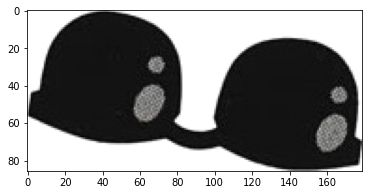

In [891]:
print(train_labels[0])
plt.imshow(train_images[0])
print(ref[1][np.where(ref[0] == train_labels[0])])

## Print test example

01
['lunettes\n']


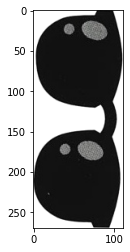

In [892]:
print(test_labels[0])
plt.imshow(test_images[0])
print(ref[1][np.where(ref[0] == test_labels[0])])

## Summary

If you executed all of the above, you defined the following variables:

```python
ref # couple:
    ref[0] # labels' identifiers
    ref[1] # labels

train_labels # train dataset's images' identifiers for labels

train_images # train dataset's images

test_labels # test dataset's images' identifiers for labels

test_images # test dataset's images
```

## Binarize image

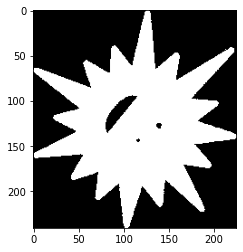

In [893]:
def is_white(pixel):
    sum_rgb = int(pixel[0]) + int(pixel[1]) + int(pixel[2])
    return sum_rgb > 700

def binarize(img):
    ret = img.copy()
    for i in range(len(img)):
        for j in range(len(img[0])):
            if is_white(img[i][j]):
                ret[i][j] = [0, 0, 0]
            else:
                ret[i][j] = [255, 255, 255]
    return ret

binary = binarize(train_images[156])
plt.imshow(binary)

## Count faces of biggest convex contour

4


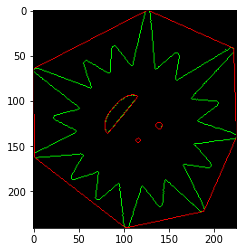

In [894]:
def count_faces(img):
    binary = binarize(img)
    imgray = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img = np.zeros((len(binary),len(binary[0]),3), np.uint8)
    cv2.drawContours(img, contours, 0, (0,255,0), 3)
    convex = np.array([])
    hull = []
    sides = []
    for i in range(len(contours)):
        cht = cv2.convexHull(contours[i], returnPoints=True)
        hull.append(cht)
        sides.append(cv2.approxPolyDP(cht, 15, True))

    drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
    for i in range(len(contours)):
        color_contours = (0, 255, 0) # green - color for contours
        color = (255, 0, 0) # blue - color for convex hull
        cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
        cv2.drawContours(drawing, hull, i, color, 1, 8)

    return len(sides[0]), drawing

nb_faces, drawing = count_faces(train_images[156])
print(nb_faces)
plt.imshow(train_images[156])
plt.imshow(drawing)

## Some rate calcs to measure efficiency

In [895]:
def face_rate(img):
    rate = count_faces(img)[0] / 10
    if rate > 1:
        return 1
    return rate

faces = []
for i in range(int(len(train_images) / 3)):
    one = face_rate(train_images[i*3])
    two = face_rate(train_images[i*3+1])
    three = face_rate(train_images[i*3+2])
    faces.append(np.abs(one - two) + np.abs(one - three) + np.abs(two - three))

sum(faces)

11.999999999999998